# plot ekman pumping in easterlies experiment .. as a function of outcropping density class

In [127]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath
import datetime as dt
import xgcm

import xesmf
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [128]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46285 Dashboard: /proxy/35551/status,Cluster Workers: 4 Cores: 8 Memory: 200.00 GiB


In [129]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [130]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

expt=control

In [131]:
variable='area_t'
area_t = cc.querying.getvar(expt,variable,master_session, n=-1)
area_t.load()
print(area_t.shape)

variable='xu_ocean'
xu_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xu_ocean.load()
print(xu_ocean.shape)

variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,master_session, n=-1)
xt_ocean.load()
print(xt_ocean.shape)

(2700, 3600)
(3600,)
(3600,)


In [132]:
#get mask of forcing region
#just do 1 year global to compare to obs
start_time='2150-01-01'
end_time='2150-01-31'
txc = cc.querying.getvar(control, 'tau_x', master_session, ncfile='ocean_month.nc',start_time=start_time, end_time=end_time)
txc = txc.sel(time=slice(start_time,end_time))
txc = txc.load()
txc

<xarray.DataArray 'tau_x' (time: 1, yu_ocean: 2700, xu_ocean: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time      (time) object 2150-01-16 12:00:00
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
Attributes:
    long_name:      i-directed wind stress forcing u-velocity
    units:          N/m^2
    valid_range:    [-10.  10.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_c geolat_c
    standard_name:  surface_downward_x_stress
    time_bounds:    <xarray.DataArray 'time_bounds' (time: 6, nv: 2)>\ndask.a...

In [133]:
#iso = xr.open_dataset('/home/561/pas561/gdv45/jnb/misc/Antarctic_isobath_1000m.nc')

In [134]:
#iso.y

In [135]:
#mask tx=0 region
#iso1mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht.yt_ocean>iso['y'])))
#iso1mask = ~xr.ufuncs.isnan(iso1mask).to_dataset(name='iso1mask')
#iso1area=area_t.where(iso1mask.iso1mask).sum(dim=('xt_ocean','yt_ocean')).compute()


In [136]:
#iso1mask

In [137]:
#z=iso1mask.to_array()
#z.plot()

In [138]:
# topography data for plotting:
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [139]:
#mask shelf regions
cstmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>300)))
cstmask = cstmask.where(~xr.ufuncs.isfinite(cstmask.where(ht.yt_ocean>-63)))
cstmask = ~xr.ufuncs.isnan(cstmask).to_dataset(name='cstmask')
cstarea=area_t.where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()


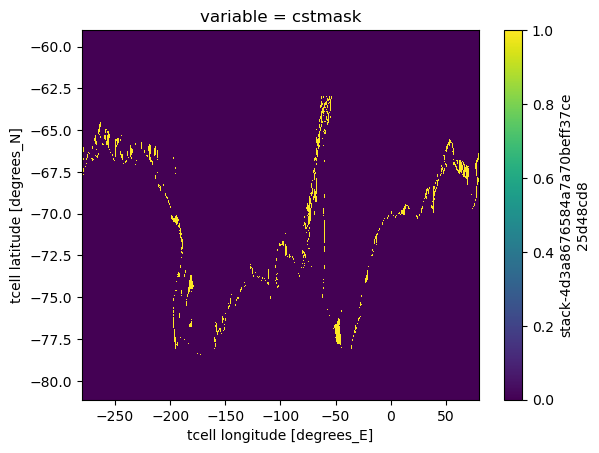

In [140]:
z=cstmask.to_array()
z.plot()

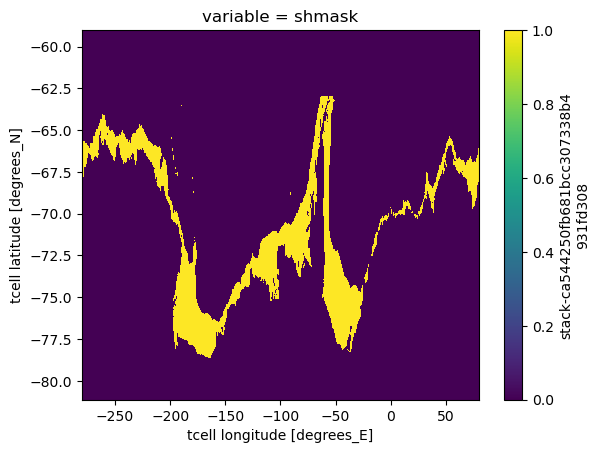

In [141]:
#mask shelf regions
shmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
shmask = shmask.where(~xr.ufuncs.isfinite(shmask.where(ht.yt_ocean>-63)))
shmask = ~xr.ufuncs.isnan(shmask).to_dataset(name='shmask')
sharea=area_t.where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

shmask=shmask.to_array()
shmask.plot()

(640,)


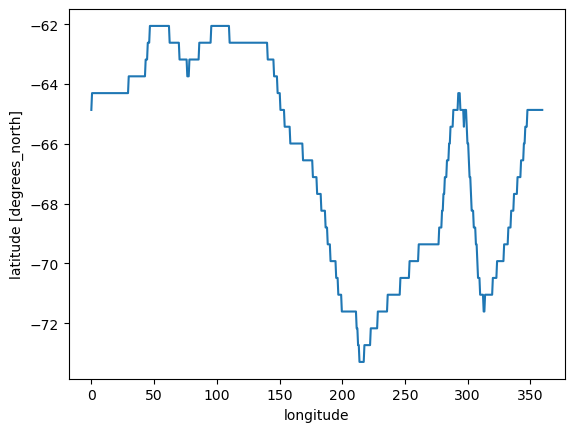

In [142]:
#make 0 windspeed area mask
#this is from windspeed input on jra grid 320 x640 - from fig. 1
fi = '/home/561/pas561/gdv45/jnb/easterlies-collaborative-project/notebooks/figures/tx0_smoothed.nc'
tx0 = xr.open_dataset(fi, decode_times = False).latitude[1:]
print(tx0.latitude.shape)
tx0.latitude.plot()

In [143]:
#regrid from jra to yt_ocean: 641 to 3600
#first change longitude from 0:360 to -280:80
#for 0-360
tx0['_lon_adj'] = xr.where(tx0['longitude'] > 80, tx0['longitude'] - 360, tx0['longitude'])

tx0 = tx0.swap_dims({'longitude': '_lon_adj'})
tx0 = tx0.sel(**{'_lon_adj': sorted(tx0._lon_adj)}).drop('longitude')
tx0 = tx0.rename({'_lon_adj': 'longitude'})

#now regrid it to xu_ocean
tx0_01=tx0.interp(longitude=xt_ocean)

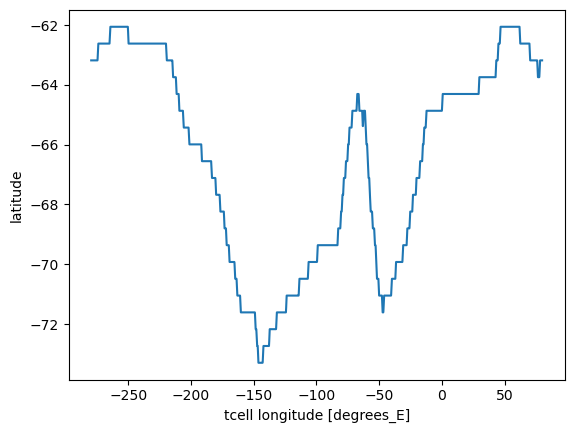

In [144]:
tx0_01.latitude.plot()

In [145]:
#mask tx=0 region
tx0mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht.yt_ocean>tx0_01.latitude)))
tx0mask = ~xr.ufuncs.isnan(tx0mask).to_dataset(name='tx0mask')
tx0area=area_t.where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()


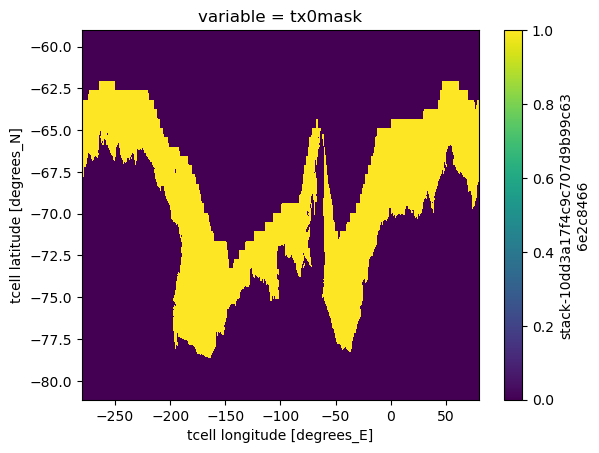

In [146]:
tx0mask=tx0mask.to_array()
tx0mask.plot()

In [147]:
tx0mask

<xarray.DataArray 'stack-10dd3a17f4c9c707d9b99c636e2c8466' (variable: 1, yt_ocean: 510, xt_ocean: 3600)>
dask.array<stack, shape=(1, 510, 3600), dtype=bool, chunksize=(1, 510, 900), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... -59.14 -59.08 -59.03
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(510, 900), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(510, 900), meta=np.ndarray>
    latitude   (xt_ocean) float64 nan nan nan nan ... -63.18 -63.18 -63.18 nan
    longitude  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * variable   (variable) <U7 'tx0mask'

In [148]:
#mask tx=0 region and ht>1000
tx0mask2 = ht.where(~xr.ufuncs.isfinite(ht.where(ht<1000)))
tx0mask2 = tx0mask2.where(~xr.ufuncs.isfinite(tx0mask2.where(ht.yt_ocean>tx0_01.latitude)))

tx0mask2 = ~xr.ufuncs.isnan(tx0mask2).to_dataset(name='tx0mask2')
tx0area2=area_t.where(tx0mask2).sum(dim=('xt_ocean','yt_ocean')).compute()


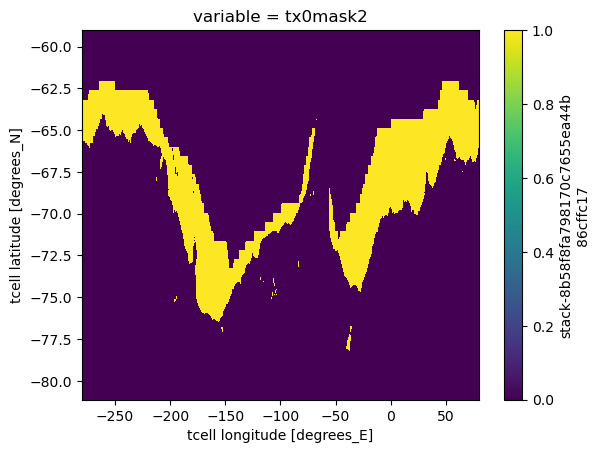

In [149]:
tx0mask2=tx0mask2.to_array()
tx0mask2.plot()

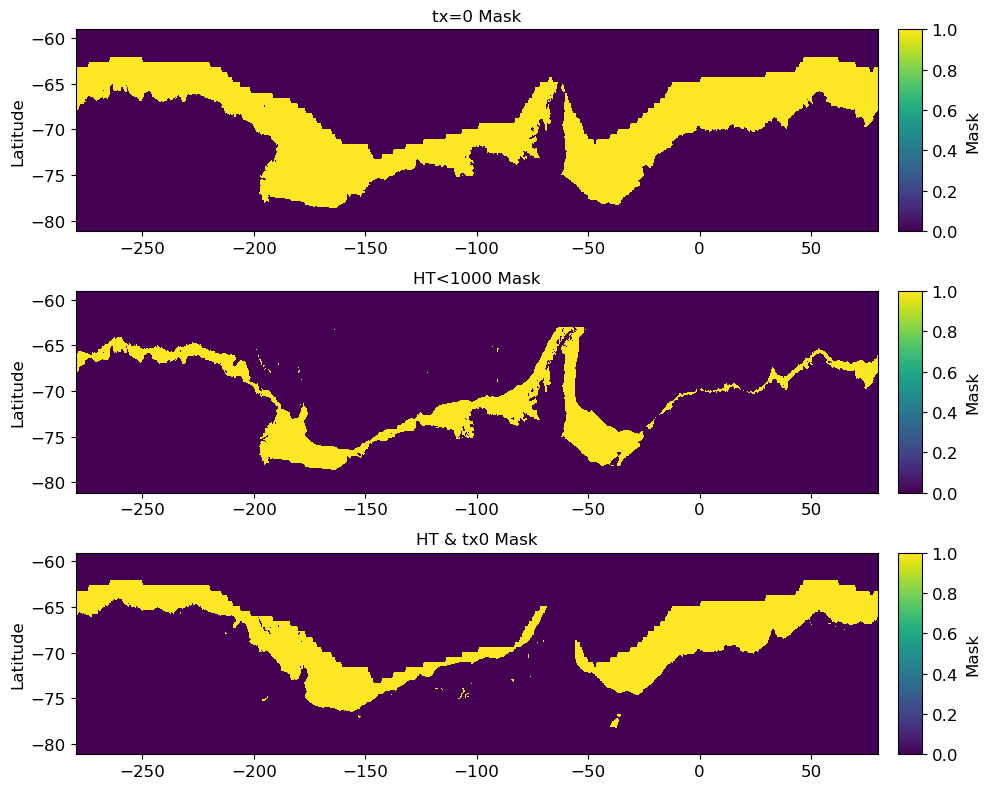

In [150]:
fontsize=12

ax=plt.figure(figsize=(10,8))
#ax.patch.set_color('.5')

plt.subplot(3,1,1)
plt.title('tx=0 Mask',fontsize=fontsize)
pc=plt.pcolormesh(tx0mask.xt_ocean,tx0mask.yt_ocean,tx0mask[0],vmin=0,vmax=1)
#plt.ylim(-75.5,-71)
#plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Mask',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.subplot(3,1,2)
plt.title('HT<1000 Mask',fontsize=fontsize)
#pc=plt.pcolormesh(tx0mask.xt_ocean,tx0mask.yt_ocean,tx0mask[0],vmin=0,vmax=1)
pc=plt.pcolormesh(shmask.xt_ocean,shmask.yt_ocean,shmask[0],vmin=0,vmax=1)
#plt.ylim(-75.5,-71)
#plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Mask',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)


plt.subplot(3,1,3)
plt.title('HT & tx0 Mask',fontsize=fontsize)
pc=plt.pcolormesh(tx0mask2.xt_ocean,tx0mask2.yt_ocean,tx0mask2[0],vmin=0,vmax=1)
#plt.ylim(-75.5,-71)
#plt.xlim(-140,-100)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],colors='k',linewidths=.5)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(pc, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Mask',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()

In [151]:
# last 5 years of simulation:
start_time='2155-01-01'
end_time='2159-12-31'
#end_time='2150-12-31'

time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# pick the northern latitude, so there are an equal number of t-cell and u-cell gridpoint in this range:
lat_slice  = slice(-82,-59.0) #-50.04-

In [1]:
tmp=xr.open_dataset('ekmanpump_control_sigma0_2150-2150.nc')
tmp

NameError: name 'xr' is not defined

In [74]:
ekman_con=xr.open_dataset('ekmanpump_control_sigma0_2150-2164.nc').sel(year=slice(2155,2159)).mean(dim='year')*-1
ekman_up=xr.open_dataset('ekmanpump_up_sigma0_2150-2164.nc').sel(year=slice(2155,2159)).mean(dim='year')*-1
ekman_down=xr.open_dataset('ekmanpump_down_sigma0_2150-2164.nc').sel(year=slice(2155,2159)).mean(dim='year')*-1

In [88]:
ekman_upz=xr.open_dataset('ekmanpump_dy_tauxf_up_sigma0_2150-2164.nc').sel(year=slice(2155,2159)).mean(dim='year') #-ve *-ve
ekman_upm=xr.open_dataset('ekmanpump_dx_tauyf_up_sigma02150-2164.nc').sel(year=slice(2155,2159)).mean(dim='year')*-1

In [89]:
ekman_upz

<xarray.Dataset>
Dimensions:         (isopycnal_bins: 51, xt_ocean: 3600, yt_ocean: 490)
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 24.05 24.15 24.25 ... 28.95 29.05
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.1 -60.05
  * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
Data variables:
    ekman_sigma0    (isopycnal_bins, yt_ocean, xt_ocean) float64 nan nan ... nan

# area integrate per rho class

In [90]:
ekman_con_aint=(ekman_con.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_aint=(ekman_up.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_aint=(ekman_upz.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_aint=(ekman_upm.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_aint=(ekman_down.ekman_sigma0*area_t).sum(dim=('xt_ocean','yt_ocean')).compute()

In [91]:
#ekman_con_coast_aint=(ekman_control.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
#ekman_up_coast_aint=(ekman_up.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()
#ekman_down_coast_aint=(ekman_down.ekman_sigma0.mean(dim='year')*area_t).where(cstmask.cstmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [92]:
ekman_con_shelf_aint=(ekman_con.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_shelf_aint=(ekman_up.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_shelf_aint=(ekman_upz.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_shelf_aint=(ekman_upm.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_shelf_aint=(ekman_down.ekman_sigma0*area_t).where(shmask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [93]:
ekman_con_tx0_aint=(ekman_con.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_tx0_aint=(ekman_up.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_tx0_aint=(ekman_upz.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_tx0_aint=(ekman_upm.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_tx0_aint=(ekman_down.ekman_sigma0*area_t).where(tx0mask[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [94]:
ekman_con_tx02_aint=(ekman_con.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_tx02_aint=(ekman_up.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upz_tx02_aint=(ekman_upz.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_upm_tx02_aint=(ekman_upm.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_tx02_aint=(ekman_down.ekman_sigma0*area_t).where(tx0mask2[0]).sum(dim=('xt_ocean','yt_ocean')).compute()

In [95]:
ekman_up_aint

<xarray.DataArray (isopycnal_bins: 51)>
array([-2.11188176e+10, -2.49331388e+10, -2.65467597e+10, -3.13045098e+10,
       -3.74185025e+10, -4.49480693e+10, -5.52007279e+10, -5.67333614e+10,
       -6.11746540e+10, -6.96494225e+10, -7.40918725e+10, -8.44483414e+10,
       -9.27033177e+10, -1.00772092e+11, -1.15184858e+11, -1.07703531e+11,
       -1.12172992e+11, -1.14869941e+11, -9.79471106e+10, -7.10556539e+10,
       -6.17110337e+10, -2.17758954e+10,  1.89617904e+10,  3.99501619e+10,
        3.30884872e+10,  3.49330983e+10,  1.52987397e+11,  2.76298039e+11,
        6.34423755e+11,  1.37977797e+12,  1.85739393e+12,  2.20765933e+12,
        2.63940969e+12,  2.56093059e+12,  1.76047700e+12,  1.39577525e+12,
        1.01220552e+12, -2.18398800e+10, -6.99448577e+11, -3.66152583e+11,
       -2.13054796e+11, -6.90122987e+10, -2.09780380e+10, -5.88090824e+09,
       -9.52863361e+09, -3.33659082e+09, -2.44748267e+09, -4.79762369e+08,
        2.72009006e+09,  8.20462316e+08, -5.37330725e+08])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 24.05 24.15 24.25 ... 28.95 29.05

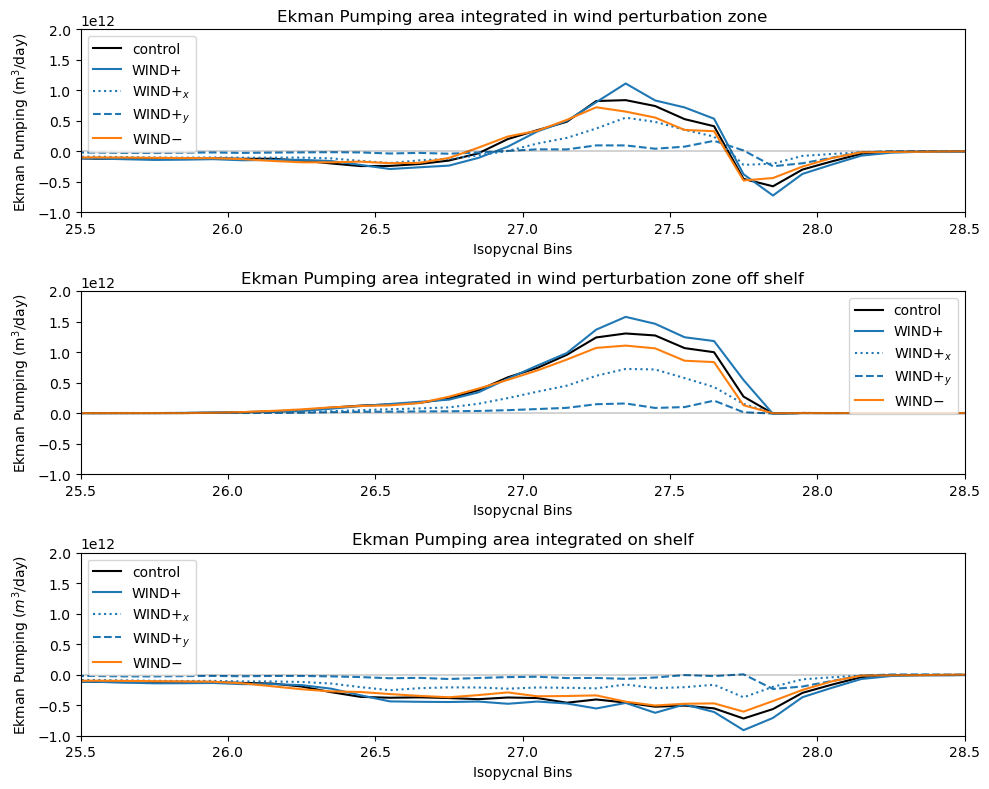

In [126]:
fontsize=12

plt.figure(figsize=(10,8))


plt.subplot(311)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx0_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_tx0_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_tx0_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx0_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
plt.xlim((25.5,28.5))
plt.ylim((-1e12,2e12))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated in wind perturbation zone')
plt.legend(fontsize=10)

plt.subplot(312)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx02_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx02_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_tx02_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_tx02_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx02_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylim((-1e12,2e12))
plt.ylabel('Ekman Pumping (m$^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated in wind perturbation zone off shelf')
plt.legend(fontsize=10)

plt.subplot(313)
plt.plot(ekman_con.isopycnal_bins,ekman_con_shelf_aint,linestyle='-',color='k',label='control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_shelf_aint,linestyle='-',color='C0',label='WIND+',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_shelf_aint,linestyle=':',color='C0',label='WIND+$_x$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_shelf_aint,linestyle='--',color='C0',label='WIND+$_y$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_shelf_aint,linestyle='-',color='C1',label='WIND$-$',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.25)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylim((-1e12,2e12))
plt.ylabel('Ekman Pumping ($m^3$/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated on shelf')
plt.legend(fontsize=10)


plt.tight_layout()

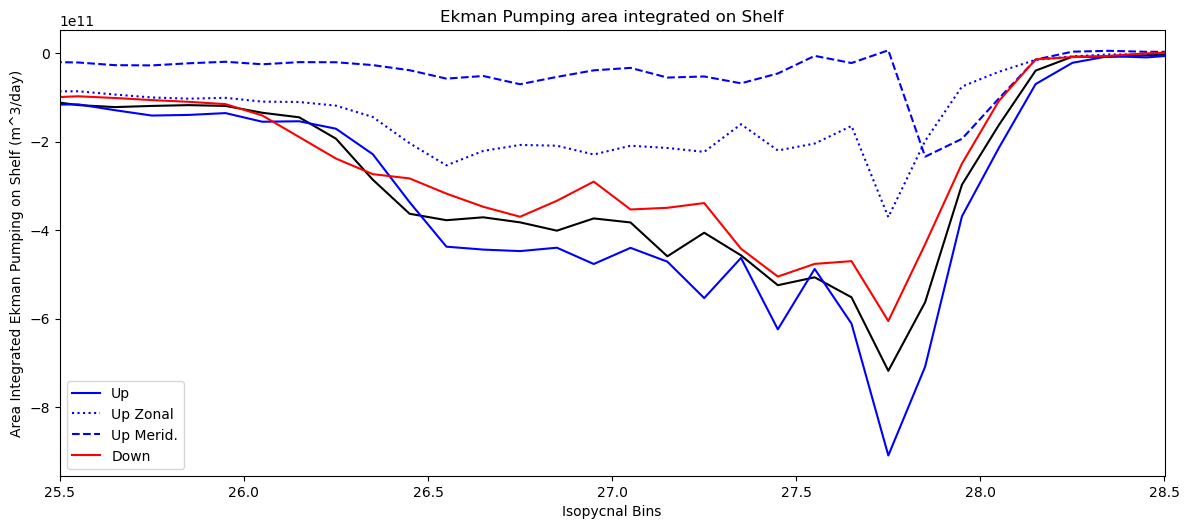

In [97]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,ekman_con_shelf_aint,linestyle='-',color='k',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_shelf_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_shelf_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_shelf_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_shelf_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping on Shelf (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated on Shelf')
plt.legend(fontsize=10)

plt.tight_layout()

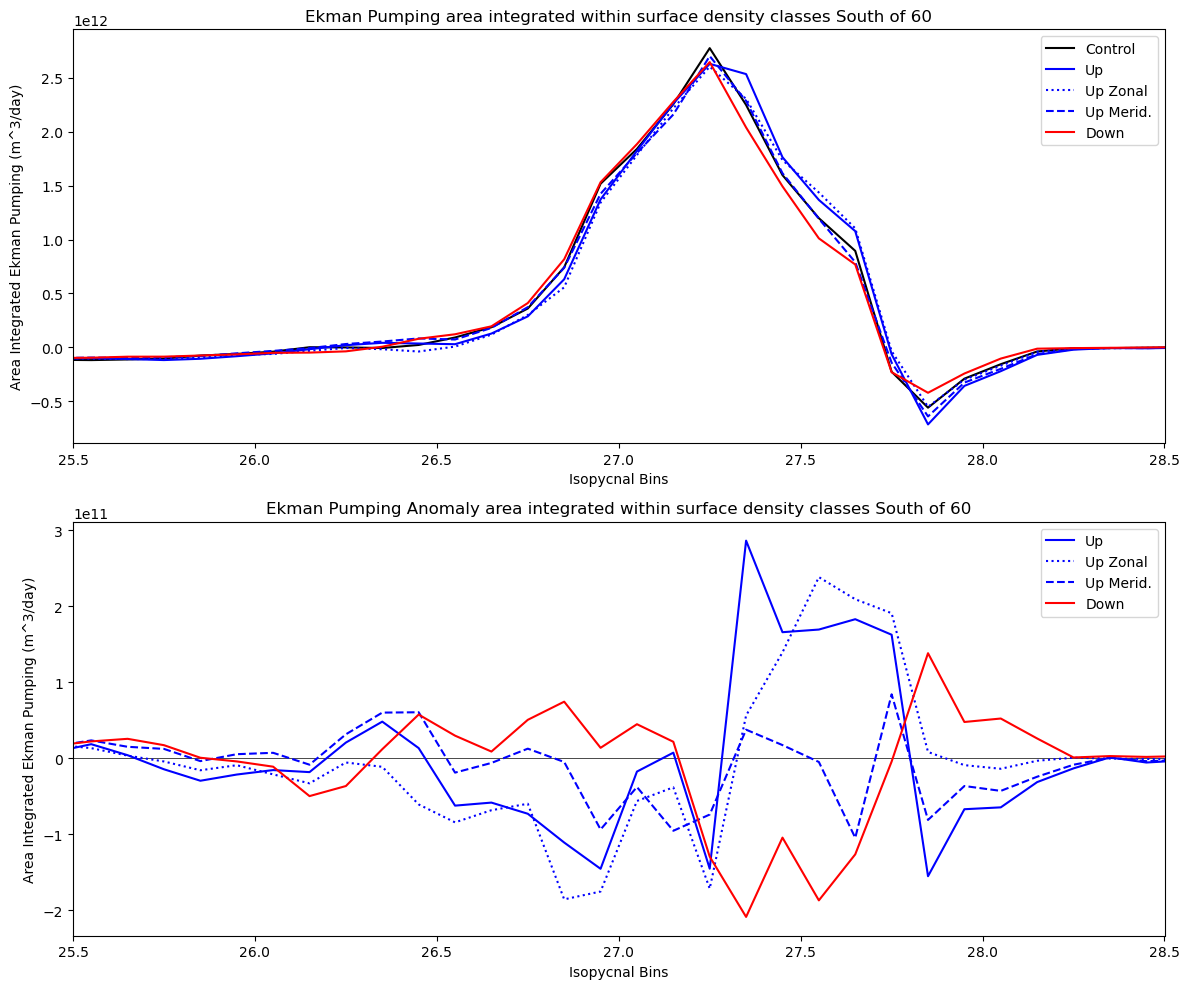

In [238]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,ekman_con_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated within surface density classes South of 60')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,ekman_con_aint-ekman_con_aint,linestyle='-',color='k',linewidth=0.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_aint-ekman_con_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_aint-ekman_con_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_aint-ekman_con_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_aint-ekman_con_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping Anomaly area integrated within surface density classes South of 60')
plt.legend(fontsize=10)

plt.tight_layout()

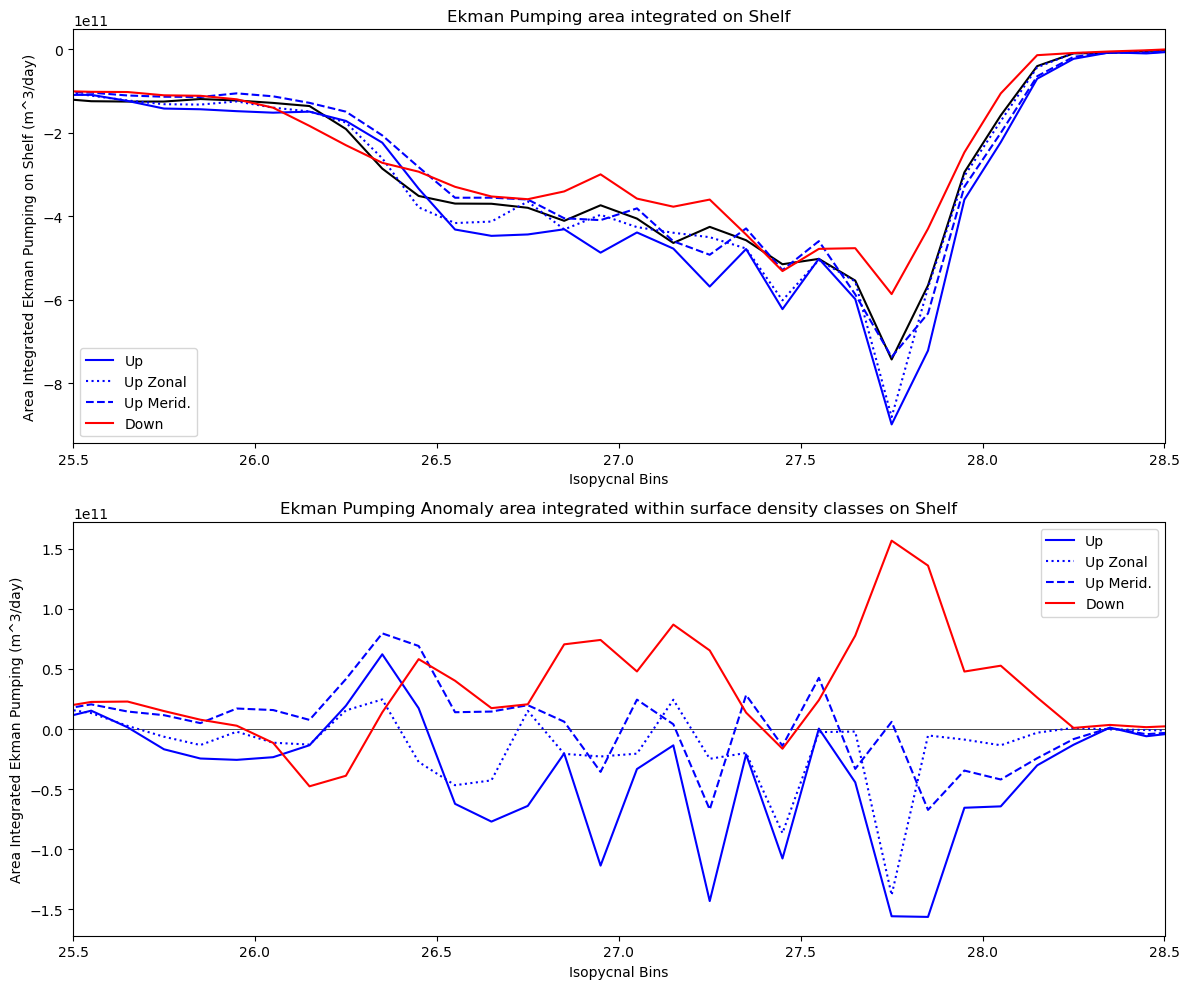

In [270]:
fontsize=12

plt.figure(figsize=(12,10))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,ekman_con_shelf_aint,linestyle='-',color='k',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_shelf_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_shelf_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_shelf_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_shelf_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping on Shelf (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated on Shelf')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,ekman_con_shelf_aint-ekman_con_shelf_aint,linestyle='-',color='k',linewidth=0.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_shelf_aint-ekman_con_shelf_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_shelf_aint-ekman_con_shelf_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_shelf_aint-ekman_con_shelf_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_shelf_aint-ekman_con_shelf_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping Anomaly area integrated within surface density classes on Shelf')
plt.legend(fontsize=10)

plt.tight_layout()

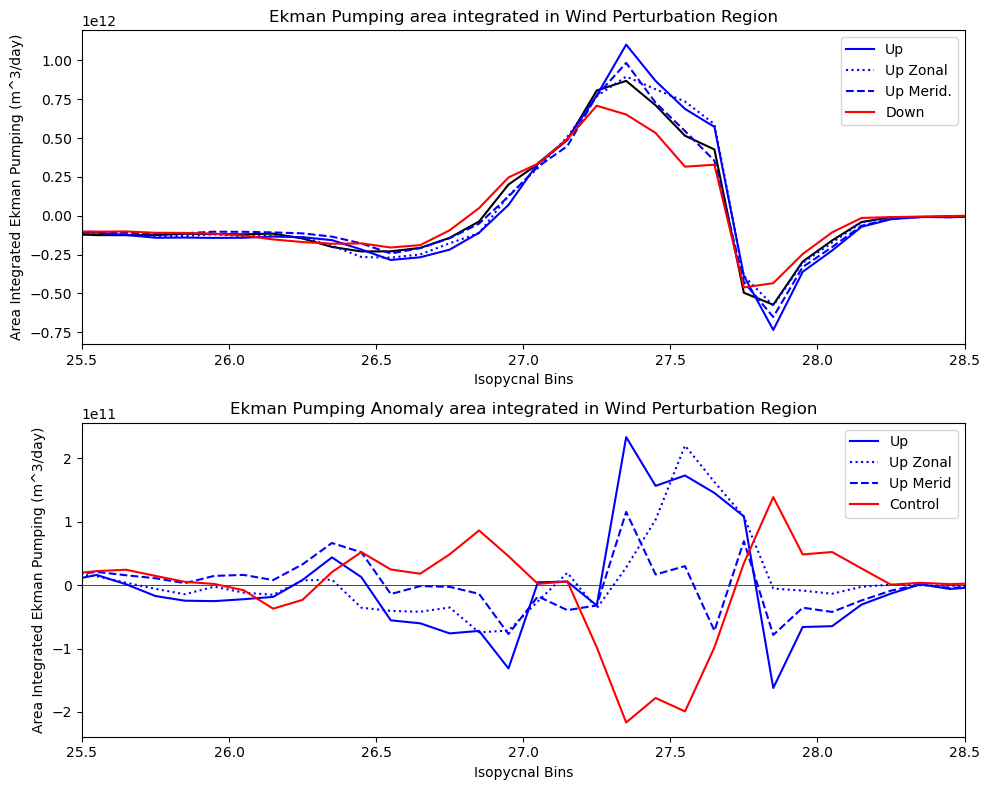

In [271]:
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint,linestyle='-',color='k',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx0_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_tx0_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_tx0_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx0_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated in Wind Perturbation Region')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,ekman_con_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='k',linewidth=0.5)
plt.plot(ekman_con.isopycnal_bins,ekman_up_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upz_tx0_aint-ekman_con_tx0_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_upm_tx0_aint-ekman_con_tx0_aint,linestyle='--',color='b',label='Up Merid',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,ekman_down_tx0_aint-ekman_con_tx0_aint,linestyle='-',color='r',label='Control',linewidth=1.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping Anomaly area integrated in Wind Perturbation Region')
plt.legend(fontsize=10)

plt.tight_layout()

## plot zonal average rho and temp to identify CDW classes

In [253]:
# Surface density:
pot_rho_0 = cc.querying.getvar(expt, 'pot_rho_0', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) - 1000
pot_rho_0 = pot_rho_0.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time') #.resample({'time':'Y'}).mean('time')
pot_rho_0

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 490, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(75, 490, 3600), dtype=float32, chunksize=(7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [252]:
temp = cc.querying.getvar(expt, 'temp', master_session, ncfile='ocean.nc',start_time=start_time, end_time=end_time) -273.13
temp = temp.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice).mean(dim='time') #.resample({'time':'Y'}).mean('time')
temp

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 490, xt_ocean: 3600)>
dask.array<mean_agg-aggregate, shape=(75, 490, 3600), dtype=float32, chunksize=(7, 300, 400), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [42]:
#needed for contour labels
rho=pot_rho_0.mean(dim='xt_ocean').compute()
rho

<xarray.DataArray 'pot_rho_0' (st_ocean: 75, yt_ocean: 490)>
array([[      nan,       nan,       nan, ..., 27.130367, 27.129353,
        27.12829 ],
       [      nan,       nan,       nan, ..., 27.130692, 27.129677,
        27.128622],
       [      nan,       nan,       nan, ..., 27.130941, 27.129927,
        27.128876],
       ...,
       [      nan,       nan,       nan, ..., 27.841833, 27.841797,
        27.841919],
       [      nan,       nan,       nan, ..., 27.841051, 27.84074 ,
        27.840538],
       [      nan,       nan,       nan, ..., 27.836014, 27.837002,
        27.837357]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [58]:
t=temp.mean(dim='xt_ocean').compute()
t

<xarray.DataArray 'temp' (st_ocean: 75, yt_ocean: 490)>
array([[        nan,         nan,         nan, ...,  0.9459783 ,
         0.97160697,  0.9981834 ],
       [        nan,         nan,         nan, ...,  0.94655555,
         0.972158  ,  0.9986878 ],
       [        nan,         nan,         nan, ...,  0.94602716,
         0.97161824,  0.998125  ],
       ...,
       [        nan,         nan,         nan, ..., -0.49542972,
        -0.49958783, -0.49213472],
       [        nan,         nan,         nan, ..., -0.48861665,
        -0.50220805, -0.50026715],
       [        nan,         nan,         nan, ..., -0.56033736,
        -0.5546589 , -0.5526337 ]], dtype=float32)
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.15 -60.1 -60.05
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

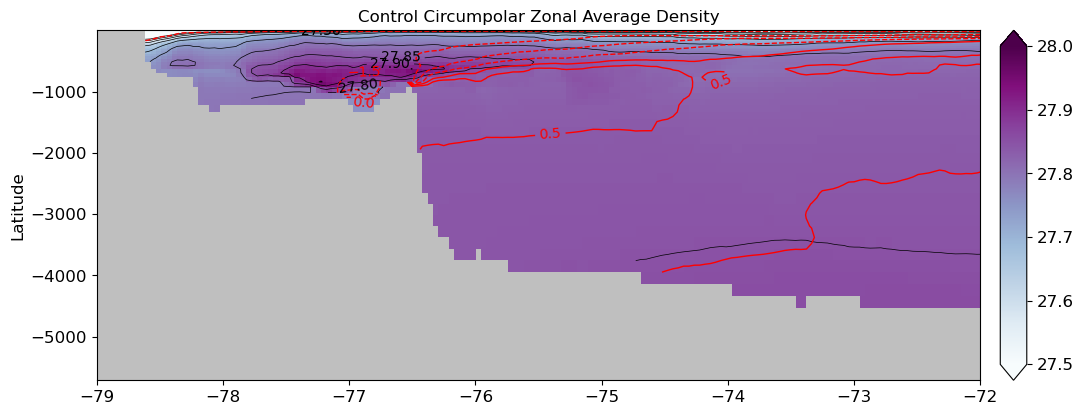

In [61]:
fontsize=12
levels=np.arange(27.5, 28., 0.05)
levels2=np.arange(-2, 6, 0.5)


plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Control Circumpolar Zonal Average Density',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-79,-72)
#plt.xlim(-140,-100)

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=27.5,vmax=28.,cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [244]:
lon_slice=slice(-140,-100)
var=ekman_con.sel(xt_ocean=lon_slice)
var

<xarray.Dataset>
Dimensions:         (isopycnal_bins: 51, xt_ocean: 400, yt_ocean: 490)
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 24.05 24.15 24.25 ... 28.95 29.05
  * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... -60.1 -60.05
  * xt_ocean        (xt_ocean) float64 -140.0 -139.9 -139.8 ... -100.2 -100.1
Data variables:
    ekman_sigma0    (isopycnal_bins, yt_ocean, xt_ocean) float64 nan nan ... nan

In [249]:
#Amundsen Region plt.xlim(-140,-100)
lon_slice=slice(-140,-100)

AS_ekman_con_shelf_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_up_shelf_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upz_shelf_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upm_shelf_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_down_shelf_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [265]:
AS_ekman_con_tx0_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_up_tx0_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upz_tx0_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_upm_tx0_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
AS_ekman_down_tx0_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()

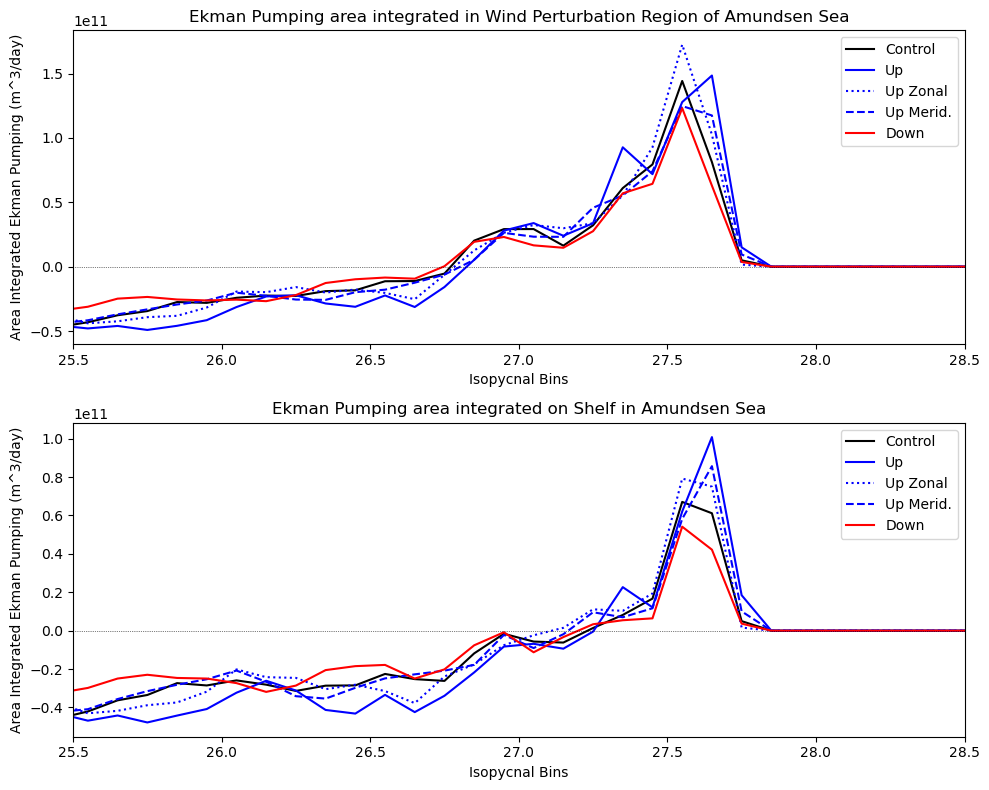

In [274]:
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx0_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_up_tx0_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upz_tx0_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upm_tx0_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_down_tx0_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx0_aint-AS_ekman_con_tx0_aint,linestyle=':',color='k',linewidth=0.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated in Wind Perturbation Region of Amundsen Sea')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_shelf_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_up_shelf_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upz_shelf_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_upm_shelf_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_down_shelf_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,AS_ekman_con_tx0_aint-AS_ekman_con_tx0_aint,linestyle=':',color='k',linewidth=0.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated on Shelf in Amundsen Sea')
plt.legend(fontsize=10)

plt.tight_layout()

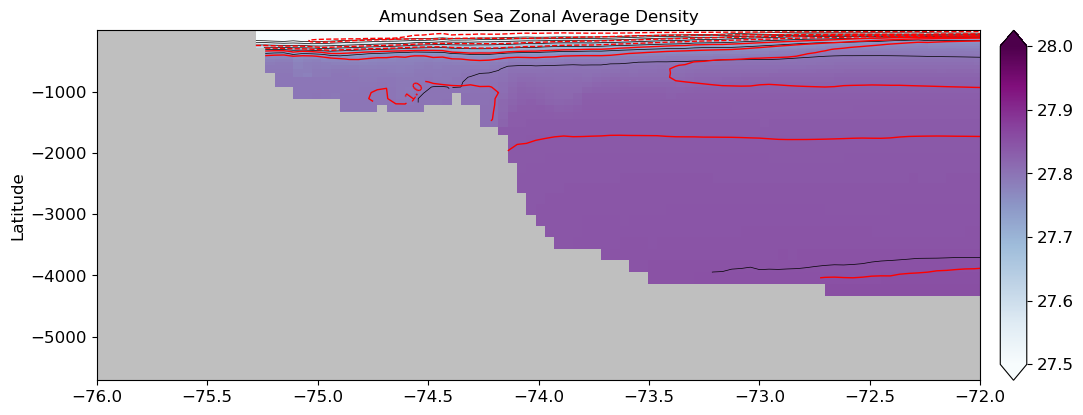

In [275]:
fontsize=12
levels=np.arange(27.5, 28., 0.05)
levels2=np.arange(-2, 6, 0.5)


plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Amundsen Sea Zonal Average Density',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-76,-72)
#plt.xlim(-140,-100)

rho=pot_rho_0.sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=27.5,vmax=28.,cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [276]:
#Denman Region
lon_slice=slice(-270,-250)

In [278]:
DM_ekman_con_shelf_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_up_shelf_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upz_shelf_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upm_shelf_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_down_shelf_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [279]:
DM_ekman_con_tx0_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_up_tx0_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upz_tx0_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_upm_tx0_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
DM_ekman_down_tx0_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()

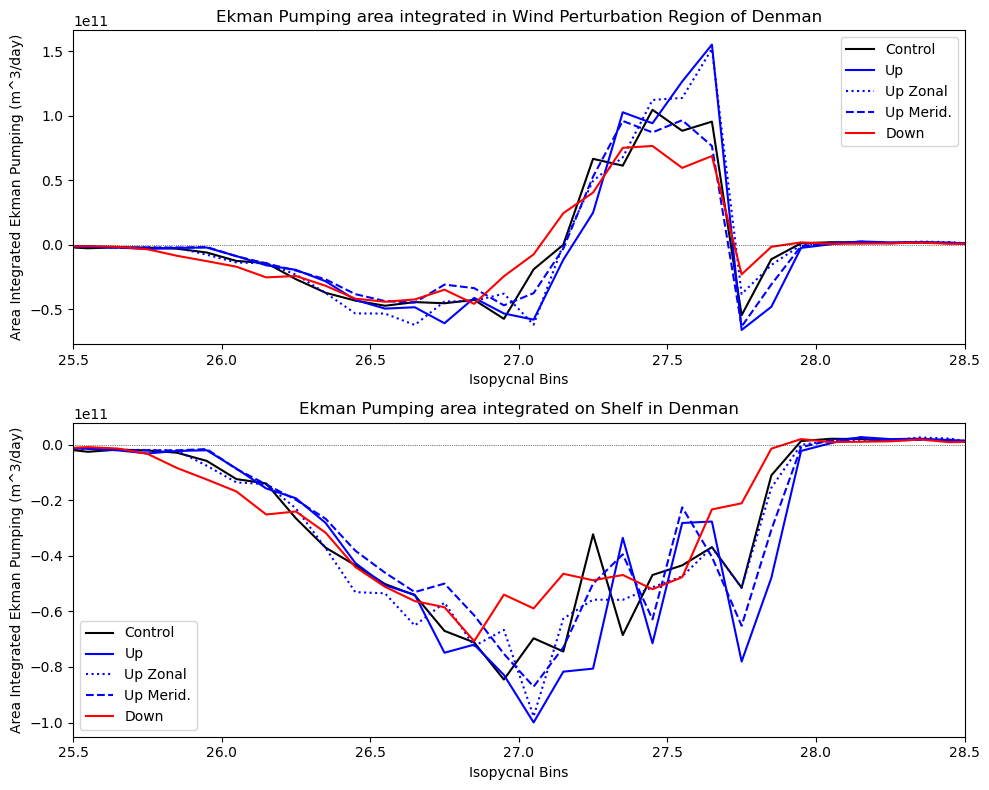

In [280]:
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx0_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_up_tx0_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upz_tx0_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upm_tx0_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_down_tx0_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx0_aint-DM_ekman_con_tx0_aint,linestyle=':',color='k',linewidth=0.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated in Wind Perturbation Region of Denman')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_shelf_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_up_shelf_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upz_shelf_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_upm_shelf_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_down_shelf_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,DM_ekman_con_tx0_aint-DM_ekman_con_tx0_aint,linestyle=':',color='k',linewidth=0.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated on Shelf in Denman')
plt.legend(fontsize=10)

plt.tight_layout()

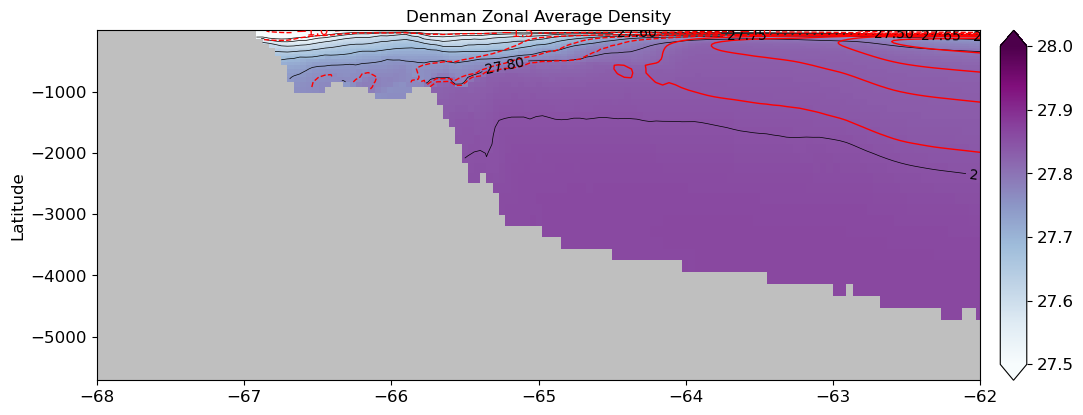

In [283]:
fontsize=12
levels=np.arange(27.5, 28., 0.05)
levels2=np.arange(-2, 6, 0.5)


plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Denman Zonal Average Density',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-68,-62)
#plt.xlim(-140,-100)

rho=pot_rho_0.sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=27.5,vmax=28.,cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

In [284]:
#weddell Region
lon_slice=slice(-63,10)

In [285]:
WS_ekman_con_shelf_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_up_shelf_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upz_shelf_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upm_shelf_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_down_shelf_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(shmask.shmask).sum(dim=('xt_ocean','yt_ocean')).compute()

In [286]:
WS_ekman_con_tx0_aint=(ekman_con.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_up_tx0_aint=(ekman_up.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upz_tx0_aint=(ekman_upz.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_upm_tx0_aint=(ekman_upm.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()
WS_ekman_down_tx0_aint=(ekman_down.sel(xt_ocean=lon_slice).ekman_sigma0*area_t).where(tx0mask.tx0mask).sum(dim=('xt_ocean','yt_ocean')).compute()

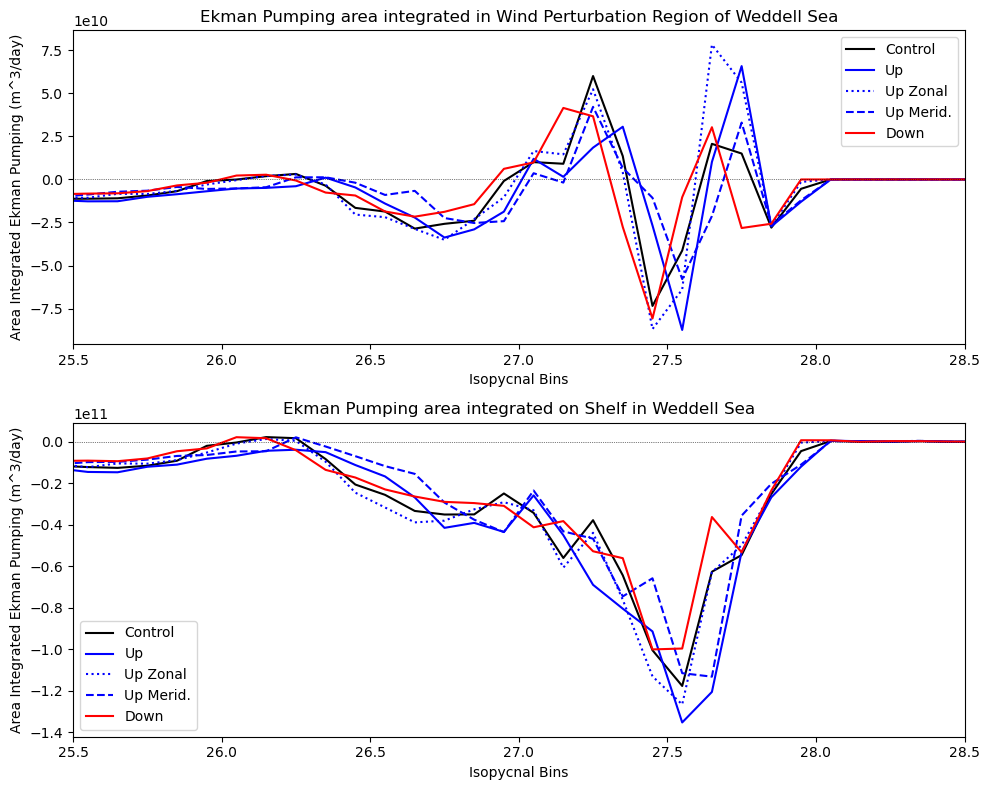

In [289]:
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx0_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_up_tx0_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upz_tx0_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upm_tx0_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_down_tx0_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx0_aint-WS_ekman_con_tx0_aint,linestyle=':',color='k',linewidth=0.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated in Wind Perturbation Region of Weddell Sea')
plt.legend(fontsize=10)

plt.subplot(212)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_shelf_aint,linestyle='-',color='k',label='Control',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_up_shelf_aint,linestyle='-',color='b',label='Up',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upz_shelf_aint,linestyle=':',color='b',label='Up Zonal',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_upm_shelf_aint,linestyle='--',color='b',label='Up Merid.',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_down_shelf_aint,linestyle='-',color='r',label='Down',linewidth=1.5)
plt.plot(ekman_con.isopycnal_bins,WS_ekman_con_tx0_aint-WS_ekman_con_tx0_aint,linestyle=':',color='k',linewidth=0.5)
#plt.plot(ekman_control.isopycnal_bins,ekman_up_coast_aint,linestyle='-',color='g',label='Up z<300m',linewidth=1.5)
plt.xlim((25.5,28.5))
plt.ylabel('Area Integrated Ekman Pumping (m^3/day)')
plt.xlabel('Isopycnal Bins')
#plt.xlim([-75,85])
plt.title('Ekman Pumping area integrated on Shelf in Weddell Sea')
plt.legend(fontsize=10)

plt.tight_layout()

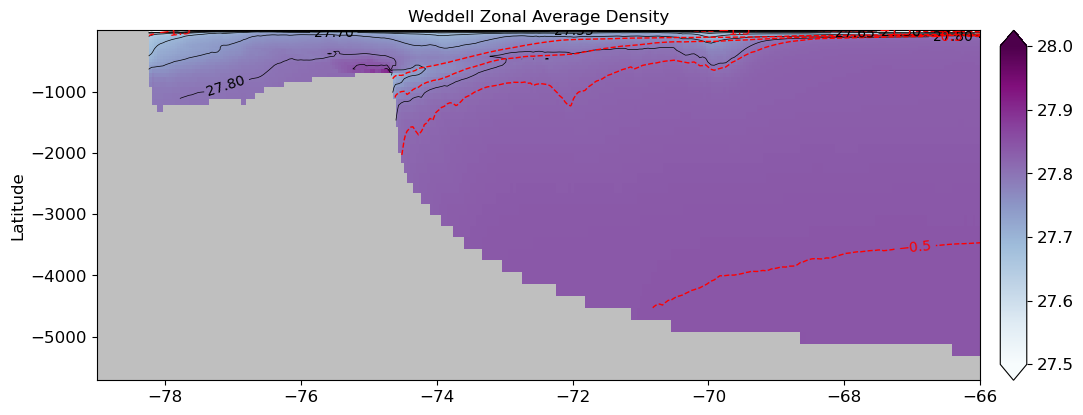

In [291]:
fontsize=12
levels=np.arange(27.5, 28., 0.05)
levels2=np.arange(-2, 6, 0.5)


plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.title('Weddell Zonal Average Density',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.xlim(-79,-66)
#plt.xlim(-140,-100)

rho=pot_rho_0.sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()
t=temp.sel(xt_ocean=lon_slice).mean(dim='xt_ocean').compute()

p1=plt.pcolormesh(rho.yt_ocean,-rho.st_ocean,rho,vmin=27.5,vmax=28.,cmap=plt.cm.BuPu)
pr=plt.contour(rho.yt_ocean,-rho.st_ocean,rho,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)

pr2=plt.contour(t.yt_ocean,-t.st_ocean,t,levels=levels2,colors='r',linewidths=1)
plt.clabel(pr2, pr2.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

## plot area average ekmanpumping per rho bin

In [12]:
ekman_control_aavg=ekman_control.ekman_sigma0.mean(dim='year').weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_aavg=ekman_up.ekman_sigma0.mean(dim='year').weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_aavg=ekman_down.ekman_sigma0.mean(dim='year').weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()


In [13]:
ekman_control_coast_aavg=ekman_control.ekman_sigma0.mean(dim='year').where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_coast_aavg=ekman_up.ekman_sigma0.mean(dim='year').where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_coast_aavg=ekman_down.ekman_sigma0.mean(dim='year').where(cstmask.cstmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()


In [14]:
ekman_control_shelf_aavg=ekman_control.ekman_sigma0.mean(dim='year').where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_up_shelf_aavg=ekman_up.ekman_sigma0.mean(dim='year').where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()
ekman_down_shelf_aavg=ekman_down.ekman_sigma0.mean(dim='year').where(shmask.shmask).weighted(area_t.fillna(0)).mean(dim=('xt_ocean','yt_ocean')).compute()


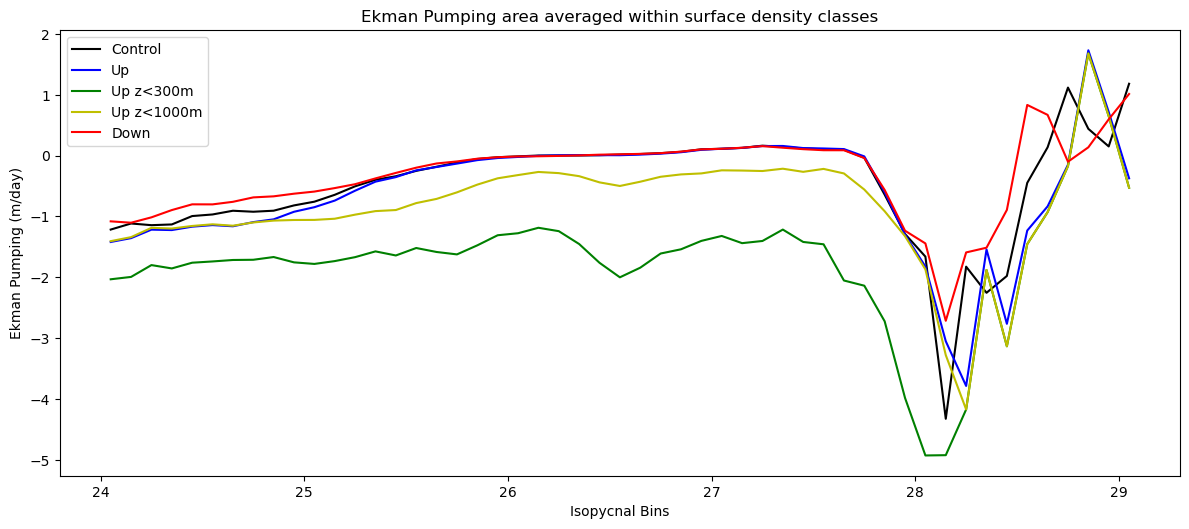

In [15]:
fontsize=12
levels=np.arange(24., 29., 0.5)


plt.figure(figsize=(12,10))

#needed for contour labels
var=pot_rho_0[0].sel(xt_ocean=slice(-150,-90))

plt.subplot(2,1,1)
plt.title('Control Surface Density Amundsen/Bellingshausen Jan',fontsize=fontsize)
plt.gca().patch.set_color('.75')
plt.ylim(-75.5,-71)
plt.xlim(-140,-100)
p1=plt.pcolormesh(var.xt_ocean,var.yt_ocean,var,vmin=isopycnal_bins[0],vmax=isopycnal_bins[-1],cmap=plt.cm.BuPu)
pr=plt.contour(var.xt_ocean,var.yt_ocean,var,levels=levels,colors='k',linewidths=0.5)
plt.clabel(pr, pr.levels, inline=True,fontsize=10)
#plt.xlabel('Longitude',fontsize=fontsize)
plt.tick_params(labelsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)
#plt.contourf(ht.xt_ocean, ht.yt_ocean,land_mask,colors='grey')

# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'both')
#cbar.set_label(r'Ekman pumping (m/day)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)
